In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install --upgrade tf_keras

In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [18]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

# Data preperation

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
import pandas as pd
import re

dataset = load_dataset("Hello-SimpleAI/HC3", name='all')
dataset1 = dataset['train'].to_pandas()

def process_dataset(dataset):
    human = dataset[['human_answers']].rename(columns={'human_answers':'text'})
    human['text'] = human['text'].apply(lambda x: ''.join(x))
    human['generated'] = 0

    ai = dataset[['chatgpt_answers']].rename(columns={'chatgpt_answers':'text'})
    ai['text'] = ai['text'].apply(lambda x: ''.join(x))
    ai['generated'] = 1

    clean_data = pd.concat((human, ai), axis=0, ignore_index=True)

    clean_data = clean_data[clean_data['text'] != '']

    return clean_data

#cleaning data
def clean(text):
    text = text.fillna("fillna")
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text


data1 = process_dataset(dataset1)
data1["text"] = clean(data1["text"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset2 = pd.read_csv("/content/drive/MyDrive/DS301GroupProject/train_v2_drcat_02.csv")

def process_df(dataset):
    dataset.drop(['prompt_name', 'source', 'RDizzl3_seven'], axis=1, inplace=True)
    dataset.rename(columns={'label': 'generated'}, inplace=True)
    return dataset

data2 = process_df(dataset2)
data2["text"] = clean(data2["text"])

In [5]:
#combined dataset
data = pd.concat([data1, data2], ignore_index=True)
data

,text,generated
0,"Basically there are many categories of "" Best ...",0
1,salt is good for not dying in car crashes and ...,0
2,The way it works is that old TV stations got a...,0
3,You ca n't just go around assassinating the le...,0
4,Wanting to kill the shit out of Germans drives...,0
...,...,...
93050,"Dear Senator, I am writing to you today to ex...",1
93051,"Dear Senator, I am writing to you today to ex...",1
93052,"Dear Senator, I am writing to you today to ex...",1
93053,"Dear Senator, I am writing to you today to ex...",1


In [8]:
x = data['text'].tolist()
y = data['generated'].astype(int).tolist()

# Tokenization Optimization

## empirical testing to find the optimal max_len on Tokens

In [ ]:
from transformers import DistilBertTokenizerFast

texts = data['text'].tolist()

# Initialize tokenizer
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenize texts and calculate lengths
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

# Create a DataFrame to analyze token lengths
lengths_df = pd.DataFrame(token_lengths, columns=['length'])

# Descriptive statistics
print(lengths_df.describe())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

             length
count  93055.000000
mean     372.374714
std      240.314604
min        3.000000
25%      215.000000
50%      323.000000
75%      468.500000
max     8834.000000


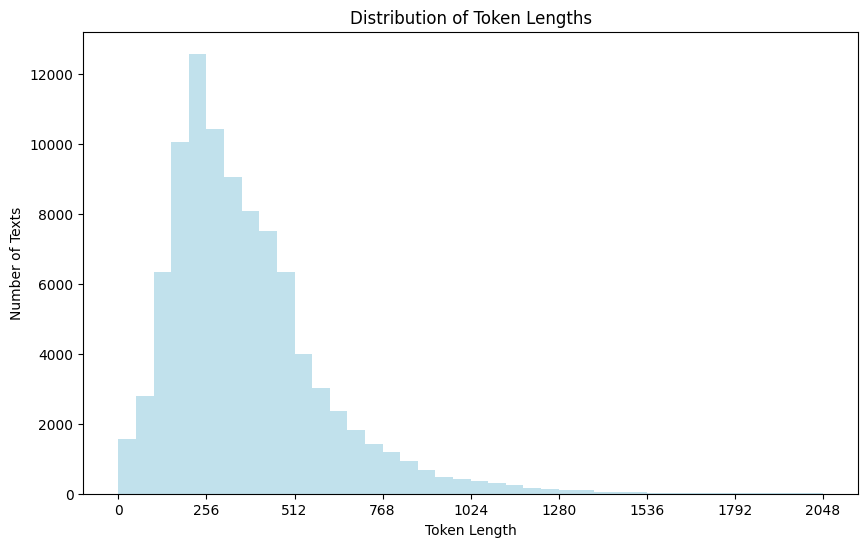

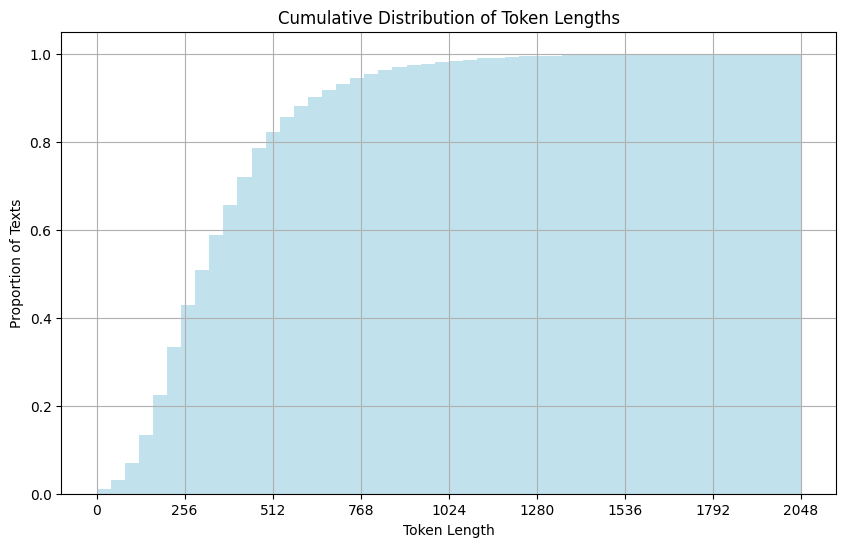

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=40, range=(0, 2048), color='lightblue', alpha=0.75)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.xticks(range(0, 2049, 256))
plt.ylabel('Number of Texts')

plt.show()

# Plot cumulative distribution to see cumulative coverage
plt.figure(figsize=(10, 6))
plt.hist(lengths_df['length'], range=(0, 2048), bins=50, cumulative=True, alpha=0.75, density=True, color='lightblue')
plt.title('Cumulative Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.xticks(range(0, 2049, 256))
plt.ylabel('Proportion of Texts')

plt.grid(True)
plt.show()


# Training Configurations

## RoBerta training on max_len = 128, batch size = 64

In [9]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification
import tensorflow as tf

# Tokenizer configuration
MODEL_NAME = 'roberta-base'
MAX_LEN = 128
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

# Encoding function remains essentially the same, though tokenizer usage may have slight differences
def construct_encodings(x, tokenizer, max_len):
    return tokenizer(x, max_length=max_len, truncation=True, padding='max_length', return_tensors='tf')

# Apply encoding to dataset
encodings = construct_encodings(x, tokenizer, MAX_LEN)

# Create Tensorflow dataset
def construct_tfdataset(encodings, y):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), y))

tfdataset = construct_tfdataset(encodings, y)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
# Split the dataset
TEST_SPLIT = 0.2
BATCH_SIZE = 64
train_size = int(len(x) * (1 - TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

# Model fitting
N_EPOCHS = 4

# Model configuration
model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Training
model.fit(tfdataset_train, epochs=N_EPOCHS)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/4
2327/2327 [==============================] - 684s 270ms/step - loss: 0.0405 - accuracy: 0.9860
Epoch 2/4
2327/2327 [==============================] - 627s 269ms/step - loss: 0.0124 - accuracy: 0.9960
Epoch 3/4
2327/2327 [==============================] - 627s 270ms/step - loss: 0.0078 - accuracy: 0.9974
Epoch 4/4
2327/2327 [==============================] - 628s 270ms/step - loss: 0.0053 - accuracy: 0.9983


In [20]:

# Evaluate the model
benchmarks = model.evaluate(tfdataset_test)
print(benchmarks)


582/582 [==============================] - 67s 97ms/step - loss: 0.0062 - accuracy: 0.9982
[0.006201636511832476, 0.9981731176376343]


### Saving finetued DistilBert model

In [21]:
import pickle

# Save the model
model.save_pretrained('/content/drive/MyDrive/DS301GroupProject/Roberta_model/clf')

# Save the tokenizer using the same path
tokenizer.save_pretrained('/content/drive/MyDrive/DS301GroupProject/Roberta_model/clf')

# Additionally, save your model configuration parameters
with open('/content/drive/MyDrive/DS301GroupProject/Roberta_model/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

### test on tweepfake and gemini dataset

In [22]:
import pandas as pd
file_path = '/content/drive/MyDrive/DS301GroupProject/tweepfake_deepfake_text_detection_test.csv'
datatweep = pd.read_csv(file_path, sep=';')

In [23]:
filtered_datatweep = datatweep.loc[datatweep['class_type'] == 'human', ['text', 'class_type']]
filtered_datatweep.rename(columns={'class_type': 'generated'}, inplace=True)
filtered_datatweep['generated'] = 0
filtered_datatweep

,text,generated
0,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,0
2,Theory: the number of red lights you will hit ...,0
4,Might give the BASIC #10Liner game contest ano...,0
7,I Wanna See Some Rainbows Out There Boys,0
...,...,...
2550,Took stock of the situation in the wake of cyc...,0
2552,"#NowPlaying ""Uno Dos (feat. Jaden)"" by ¿Téo? i...",0
2554,Love the Choose your own adventure style of th...,0
2556,These deeply discounted 256GB SanDisk flash dr...,0


In [24]:
file_path2 = '/content/drive/MyDrive/DS301GroupProject/train_essays_v1.csv'
gemini = pd.read_csv(file_path2, sep=';')
gemini.rename(columns={'text,label,prompt_name,source,RDizzl3_seven': 'text'}, inplace=True)
gemini['generated'] = 1
gemini

,text,generated
0,The Electoral College is a complex system that...,1
1,"The exploration of Venus, Earth's closest plan...",1
2,## Does the Electoral College Work?\n\nThe Ele...,1
3,"In the vast realm of literature, there exists ...",1
4,"In the realm of modern transportation, the adv...",1
...,...,...
3495,"The Electoral College, a distinctive feature o...",1
3496,The Electoral College is a system of indirect ...,1
3497,"The electoral College, an integral part of the...",1
3498,"The Electoral College, a distinctive feature o...",1


In [25]:
gemini_test_df = pd.concat([filtered_datatweep, gemini], ignore_index=True)
gemini_test_df['text'] = clean(gemini_test_df['text'])

In [26]:
gemini_test_df

,text,generated
0,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,0
2,Theory: the number of red lights you will hit ...,0
3,Might give the BASIC #10Liner game contest ano...,0
4,I Wanna See Some Rainbows Out There Boys,0
...,...,...
4773,"The Electoral College, a distinctive feature o...",1
4774,The Electoral College is a system of indirect ...,1
4775,"The electoral College, an integral part of the...",1
4776,"The Electoral College, a distinctive feature o...",1


In [27]:
# Apply encoding to dataset
encodings_2 = construct_encodings(gemini_test_df['text'].tolist(), tokenizer, MAX_LEN)

tfdataset_2 = construct_tfdataset(encodings_2, gemini_test_df['generated'].tolist())


In [28]:
benchmarks_2 = model.evaluate(tfdataset_2.batch(BATCH_SIZE))
print(benchmarks_2)

150/150 [==============================] - 15s 97ms/step - loss: 0.0863 - accuracy: 0.9797
[0.08632616698741913, 0.9796985983848572]


### test on US ai-patents dataset

In [29]:
!git clone https://github.com/MIRICMILAN/US-AI-Patents.git

Cloning into 'US-AI-Patents'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 97 (delta 1), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (97/97), 1.87 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [30]:
import pandas as pd

path = "/content/US-AI-Patents/Training Data/4K Patents - AI 20p.csv"
df = pd.read_csv(path)
df

,Unnamed: 0,app number,actual,abstract,ipc c,application year
0,0,US7070215B2,0,Tilt latch mechanism for hung windows a dual f...,E0,2004
1,1,US9018239B2,0,Treatment of edible crops in the growing of cr...,A0,2012
2,2,US5257045A,0,Ionographic printing with a focused ion stream...,G0,1992
3,3,US6507704B2,0,Pseudo zoom camera and image processing system...,G0,2001
4,4,US9256249B2,0,Stand assembly and monitor a system can includ...,H0 A4 G0 E0 F1,2013
...,...,...,...,...,...,...
3995,3995,US4580513A,1,Pattern selecting device for electronic sewing...,D0,1983
3996,3996,US9066615B2,1,Feeding assistant robot the present invention ...,A4 B2 A6,2010
3997,3997,US8995619B2,1,Personnel screening system the present specifi...,G0,2011
3998,3998,US9519805B2,0,Digest obfuscation for data cryptography execu...,G0,2013


In [31]:
df_new = df[['actual', 'abstract']]
df_new

,actual,abstract
0,0,Tilt latch mechanism for hung windows a dual f...
1,0,Treatment of edible crops in the growing of cr...
2,0,Ionographic printing with a focused ion stream...
3,0,Pseudo zoom camera and image processing system...
4,0,Stand assembly and monitor a system can includ...
...,...,...
3995,1,Pattern selecting device for electronic sewing...
3996,1,Feeding assistant robot the present invention ...
3997,1,Personnel screening system the present specifi...
3998,0,Digest obfuscation for data cryptography execu...


In [32]:
# If you want to rename the columns
new_column_names = {'actual': 'generated', 'abstract': 'text'}
selected_columns = df_new.rename(columns=new_column_names)

In [33]:
selected_columns['text'] = clean(selected_columns['text'])

In [34]:
selected_columns

,generated,text
0,0,Tilt latch mechanism for hung windows a dual f...
1,0,Treatment of edible crops in the growing of cr...
2,0,Ionographic printing with a focused ion stream...
3,0,Pseudo zoom camera and image processing system...
4,0,Stand assembly and monitor a system can includ...
...,...,...
3995,1,Pattern selecting device for electronic sewing...
3996,1,Feeding assistant robot the present invention ...
3997,1,Personnel screening system the present specifi...
3998,0,Digest obfuscation for data cryptography execu...


In [35]:
# Apply encoding to dataset
encodings_3 = construct_encodings(selected_columns['text'].tolist(), tokenizer, MAX_LEN)
tfdataset_3 = construct_tfdataset(encodings_3, selected_columns['generated'].tolist())


In [36]:
benchmarks_3 = model.evaluate(tfdataset_3.batch(BATCH_SIZE))
print(benchmarks_3)

125/125 [==============================] - 12s 97ms/step - loss: 2.1748 - accuracy: 0.7990
[2.1748273372650146, 0.7990000247955322]


## AlBert Training on max_len = 128, batch_size = 64

In [37]:
from transformers import AlbertTokenizerFast, TFAlbertForSequenceClassification
import tensorflow as tf

# Tokenizer and model configuration
MODEL_NAME = 'albert-base-v2'
MAX_LEN = 128
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_NAME)

def construct_encodings(x, tokenizer, max_len):
    return tokenizer(x, max_length=max_len, truncation=True, padding='max_length', return_tensors='tf')

# Apply encoding to dataset
encodings = construct_encodings(x, tokenizer, MAX_LEN)

# Create Tensorflow dataset
def construct_tfdataset(encodings, y):
    return tf.data.Dataset.from_tensor_slices((dict(encodings), y))

tfdataset = construct_tfdataset(encodings, y)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [38]:
# Split the dataset
TEST_SPLIT = 0.2
BATCH_SIZE = 64
train_size = int(len(x) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(x))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

# Model fitting
N_EPOCHS = 4
model_albert = TFAlbertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_albert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model_albert.fit(tfdataset_train, epochs=N_EPOCHS)


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
1164/1164 [==============================] - 590s 483ms/step - loss: 0.0529 - accuracy: 0.9815
Epoch 2/4
1164/1164 [==============================] - 562s 483ms/step - loss: 0.0215 - accuracy: 0.9932
Epoch 3/4
1164/1164 [==============================] - 562s 483ms/step - loss: 0.0136 - accuracy: 0.9957
Epoch 4/4
1164/1164 [==============================] - 562s 483ms/step - loss: 0.0095 - accuracy: 0.9970


In [39]:
# Evaluate the model
benchmarks = model_albert.evaluate(tfdataset_test)
print(benchmarks)

291/291 [==============================] - 61s 181ms/step - loss: 0.0077 - accuracy: 0.9977
[0.00765596516430378, 0.9976895451545715]


In [40]:
import pickle

# Save the model
model.save_pretrained('/content/drive/MyDrive/DS301GroupProject/model_albert/clf')

# Save the tokenizer using the same path
tokenizer.save_pretrained('/content/drive/MyDrive/DS301GroupProject/model_albert/clf')

# Additionally, save your model configuration parameters
with open('/content/drive/MyDrive/DS301GroupProject/model_albert/info.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LEN), f)

### test on tweepfake and gemini dataset

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/DS301GroupProject/tweepfake_deepfake_text_detection_test.csv'
datatweep = pd.read_csv(file_path, sep=';')

In [ ]:
filtered_datatweep = datatweep.loc[datatweep['class_type'] == 'human', ['text', 'class_type']]
filtered_datatweep.rename(columns={'class_type': 'generated'}, inplace=True)
filtered_datatweep['generated'] = 0
filtered_datatweep

,text,generated
0,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,0
2,Theory: the number of red lights you will hit ...,0
4,Might give the BASIC #10Liner game contest ano...,0
7,I Wanna See Some Rainbows Out There Boys,0
...,...,...
2550,Took stock of the situation in the wake of cyc...,0
2552,"#NowPlaying ""Uno Dos (feat. Jaden)"" by ¿Téo? i...",0
2554,Love the Choose your own adventure style of th...,0
2556,These deeply discounted 256GB SanDisk flash dr...,0


In [ ]:
file_path2 = '/content/drive/MyDrive/DS301GroupProject/train_essays_v1.csv'
gemini = pd.read_csv(file_path2, sep=';')
gemini.rename(columns={'text,label,prompt_name,source,RDizzl3_seven': 'text'}, inplace=True)
gemini['generated'] = 1
gemini

,text,generated
0,The Electoral College is a complex system that...,1
1,"The exploration of Venus, Earth's closest plan...",1
2,## Does the Electoral College Work?\n\nThe Ele...,1
3,"In the vast realm of literature, there exists ...",1
4,"In the realm of modern transportation, the adv...",1
...,...,...
3495,"The Electoral College, a distinctive feature o...",1
3496,The Electoral College is a system of indirect ...,1
3497,"The electoral College, an integral part of the...",1
3498,"The Electoral College, a distinctive feature o...",1


In [ ]:
gemini_test_df = pd.concat([filtered_datatweep, gemini], ignore_index=True)
gemini_test_df['text'] = clean(gemini_test_df['text'])

In [ ]:
gemini_test_df

,text,generated
0,justin timberlake really one of the goats if y...,0
1,thank you @pmbhutan for your gracious prayers ...,0
2,theory: the number of red lights you will hit ...,0
3,might give the basic #10liner game contest ano...,0
4,i wanna see some rainbows out there boys,0
...,...,...
4773,"the electoral college, a distinctive feature o...",1
4774,the electoral college is a system of indirect ...,1
4775,"the electoral college, an integral part of the...",1
4776,"the electoral college, a distinctive feature o...",1


In [ ]:
MAX_LEN

256

In [ ]:
BATCH_SIZE

64

In [41]:
# Apply encoding to dataset
encodings_2 = construct_encodings(gemini_test_df['text'].tolist(), tokenizer, MAX_LEN)

tfdataset_2 = construct_tfdataset(encodings_2, gemini_test_df['generated'].tolist())


In [42]:
benchmarks_2 = model_albert.evaluate(tfdataset_2.batch(BATCH_SIZE))
print(benchmarks_2)

75/75 [==============================] - 14s 181ms/step - loss: 0.0451 - accuracy: 0.9820
[0.04511909931898117, 0.9820008277893066]


### test on US ai-patents dataset

In [ ]:
!git clone https://github.com/MIRICMILAN/US-AI-Patents.git

Cloning into 'US-AI-Patents'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 97 (delta 1), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (97/97), 1.87 MiB | 25.48 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
import pandas as pd

path = "/content/US-AI-Patents/Training Data/4K Patents - AI 20p.csv"
df = pd.read_csv(path)
df

,Unnamed: 0,app number,actual,abstract,ipc c,application year
0,0,US7070215B2,0,Tilt latch mechanism for hung windows a dual f...,E0,2004
1,1,US9018239B2,0,Treatment of edible crops in the growing of cr...,A0,2012
2,2,US5257045A,0,Ionographic printing with a focused ion stream...,G0,1992
3,3,US6507704B2,0,Pseudo zoom camera and image processing system...,G0,2001
4,4,US9256249B2,0,Stand assembly and monitor a system can includ...,H0 A4 G0 E0 F1,2013
...,...,...,...,...,...,...
3995,3995,US4580513A,1,Pattern selecting device for electronic sewing...,D0,1983
3996,3996,US9066615B2,1,Feeding assistant robot the present invention ...,A4 B2 A6,2010
3997,3997,US8995619B2,1,Personnel screening system the present specifi...,G0,2011
3998,3998,US9519805B2,0,Digest obfuscation for data cryptography execu...,G0,2013


In [ ]:
df_new = df[['actual', 'abstract']]
df_new

,actual,abstract
0,0,Tilt latch mechanism for hung windows a dual f...
1,0,Treatment of edible crops in the growing of cr...
2,0,Ionographic printing with a focused ion stream...
3,0,Pseudo zoom camera and image processing system...
4,0,Stand assembly and monitor a system can includ...
...,...,...
3995,1,Pattern selecting device for electronic sewing...
3996,1,Feeding assistant robot the present invention ...
3997,1,Personnel screening system the present specifi...
3998,0,Digest obfuscation for data cryptography execu...


In [ ]:
# If you want to rename the columns
new_column_names = {'actual': 'generated', 'abstract': 'text'}
selected_columns = df_new.rename(columns=new_column_names)

In [ ]:
selected_columns['text'] = clean(selected_columns['text'])

In [ ]:
selected_columns

,generated,text
0,0,tilt latch mechanism for hung windows a dual f...
1,0,treatment of edible crops in the growing of cr...
2,0,ionographic printing with a focused ion stream...
3,0,pseudo zoom camera and image processing system...
4,0,stand assembly and monitor a system can includ...
...,...,...
3995,1,pattern selecting device for electronic sewing...
3996,1,feeding assistant robot the present invention ...
3997,1,personnel screening system the present specifi...
3998,0,digest obfuscation for data cryptography execu...


In [43]:
# Apply encoding to dataset
encodings_3 = construct_encodings(selected_columns['text'].tolist(), tokenizer, MAX_LEN)
tfdataset_3 = construct_tfdataset(encodings_3, selected_columns['generated'].tolist())


In [44]:
benchmarks_3 = model_albert.evaluate(tfdataset_3.batch(BATCH_SIZE))
print(benchmarks_3)

63/63 [==============================] - 11s 179ms/step - loss: 1.7362 - accuracy: 0.7880
[1.7362172603607178, 0.7879999876022339]
